#### `Decision Tree Classification`

##### `Target: Species`

In [1]:
from warnings import filterwarnings
filterwarnings("ignore")

In [2]:
#Step-1: Data Ingestion
import pandas as pd
df = pd.read_csv("iris.csv")
df.head(1)

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa


In [3]:
#Step-2: Data Sanity - Duplicate removals
# Duplicate Data
duplicate_count = df.duplicated().sum()

if duplicate_count > 0:
    print(f'Duplicates Found: {duplicate_count}')
    print('Removing Duplicates...')
    df = df.drop_duplicates(keep = "first").reset_index(drop = True)
    print('Removed Duplicates...')
    df.shape
else:
    print('No Duplicates Found')

Duplicates Found: 1
Removing Duplicates...
Removed Duplicates...


In [4]:
#Step-3: Separate X and Y
X = df.drop(columns = ["species"])
Y = df["species"]
X.head(1)

,sepal_length,sepal_width,petal_length,petal_width
0,5.1,3.5,1.4,0.2


In [5]:
#Step-4: Remove High Unique Cat Cols
card = df.select_dtypes(include = "object").nunique() / len(df)
high_card = card[card >= 0.9]
high_card
X = X.drop(columns = high_card.index)

In [7]:
#Step-5: Train Test Split
from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.33, random_state=42)
xtrain.shape, xtest.shape

((99, 4), (50, 4))

In [8]:
#Step-6: Apply Preprocessing on X
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer

In [9]:
pipe = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler()
).set_output(transform= "pandas")

In [10]:
pipe.fit(xtrain)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('simpleimputer', ...), ('standardscaler', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"missing_values missing_values: int, float, str, np.nan, None or pandas.NA, default=np.nanThe placeholder for the missing values. All occurrences of`missing_values` will be imputed. For pandas' dataframes withnullable integer dtypes with missing values, `missing_values`can be set to either `np.nan` or `pd.NA`.",nan
,"strategy strategy: str or Callable, default='mean'The imputation strategy.- If ""mean"", then replace missing values using the mean along each column. Can only be used with numeric data.- If ""median"", then replace missing values using the median along each column. Can only be used with numeric data.- If ""most_frequent"", then replace missing using the most frequent value along each column. Can be used with strings or numeric data. If there is more than one such value, only the smallest is returned.- If ""constant"", then replace missing values with fill_value. Can be used with strings or numeric data.- If an instance of Callable, then replace missing values using the scalar statistic returned by running the callable over a dense 1d array containing non-missing values of each column... versionadded:: 0.20 strategy=""constant"" for fixed value imputation... versionadded:: 1.5 strategy=callable for custom value imputation.",'median'
,"fill_value fill_value: str or numerical value, default=NoneWhen strategy == ""constant"", `fill_value` is used to replace alloccurrences of missing_values. For string or object data types,`fill_value` must be a string.If `None`, `fill_value` will be 0 when imputing numericaldata and ""missing_value"" for strings or object data types.",None
,"copy copy: bool, default=TrueIf True, a copy of X will be created. If False, imputation willbe done in-place whenever possible. Note that, in the following cases,a new copy will always be made, even if `copy=False`:- If `X` is not an array of floating values;- If `X` is encoded as a CSR matrix;- If `add_indicator=True`.",True
,"add_indicator add_indicator: bool, default=FalseIf True, a :class:`MissingIndicator` transform will stack onto outputof the imputer's transform. This allows a predictive estimatorto account for missingness despite impu

In [11]:
xtrain_pre = pipe.transform(xtrain)
print(xtrain_pre.head(1))
xtest_pre = pipe.transform(xtest)
print(xtest.head(1))

    sepal_length  sepal_width  petal_length   petal_width
95     -0.123796     0.017101      0.241765 -3.037022e-16
    sepal_length  sepal_width  petal_length  petal_width
73           6.1          2.8           4.7          1.2


In [15]:
#Step-7: Build Model: DecisionTree
from sklearn.tree import DecisionTreeClassifier
dtc_model = DecisionTreeClassifier(
    max_depth = 1,
    min_samples_split = 5,
    min_samples_leaf = 5,
    random_state=42
)

dtc_model.fit(xtrain_pre, ytrain)

,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.",'gini'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",1
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",5
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",5
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... note:: The search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than ``max_features`` features.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness of the estimator. The features are alwaysrandomly permuted at each split, even if ``splitter`` is set to``""best""``. When ``max_features < n_features``, the algorithm willselect ``max_features`` at random at each split before finding the bestsplit among them. But the best found split may vary across differentruns, even if ``max_features=n_features``. That is the case, if theimprovement of the criterion is identical for several splits and onesplit has to be selected at random. To obtain a deterministic behaviourduring fitting, ``random_state`` has to be fixed to an integer.See :term:`Glossary ` for details.",42
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow a tree with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current no

In [16]:
print(f'Train Model Score: {dtc_model.score(xtrain_pre, ytrain)}')
print(f'Test Model Score: {dtc_model.score(xtest_pre, ytest)}')

Train Model Score: 0.6666666666666666
Test Model Score: 0.68


In [18]:
#Step-8: Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV
params = {
    "max_depth": [2,3,4,5],
    "min_samples_split": [5,6,7,8],
    "min_samples_leaf": [5,6,7,8]
}

base_dtc = DecisionTreeClassifier(random_state=42)

gscv = GridSearchCV(
    base_dtc, params, cv=5, scoring="f1_macro"
)

gscv.fit(xtrain_pre, ytrain)

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",DecisionTreeC...ndom_state=42)
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'max_depth': [2, 3, ...], 'min_samples_leaf': [5, 6, ...], 'min_samples_split': [5, 6, ...]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'f1_macro'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",None
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate is displaye

In [19]:
best_dtc = gscv.best_estimator_

In [20]:
print(f'Best DTC Train Model Score: {best_dtc.score(xtrain_pre, ytrain)}')
print(f'Best DTC Test Model Score: {best_dtc.score(xtest_pre, ytest)}')

Best DTC Train Model Score: 0.9393939393939394
Best DTC Test Model Score: 1.0


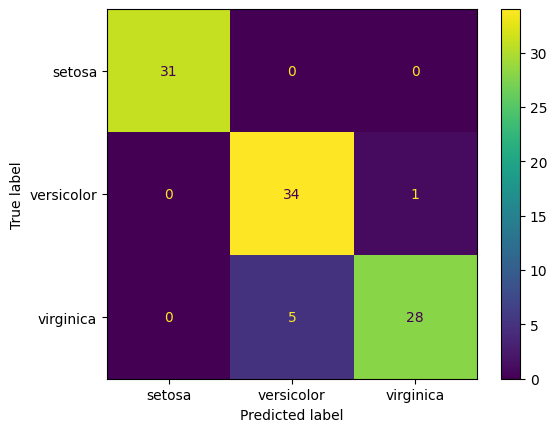

In [23]:
#Step-9: Evaluate Model
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(best_dtc, xtrain_pre, ytrain)

In [26]:
from sklearn.metrics import classification_report
ypred_pre = best_dtc.predict(xtest_pre)
print(classification_report(ytest, ypred_pre))


              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        19
  versicolor       1.00      1.00      1.00        15
   virginica       1.00      1.00      1.00        16

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50



In [27]:
best_dtc.feature_importances_

array([0.00563759, 0.        , 0.94236752, 0.05199489])

In [28]:
#Step-10: Model Inference (Out of Sample Prediction)
xnew = pd.read_csv('iris_sample.csv')
xnew.head(1)

,sepal_length,sepal_width,petal_length,petal_width
0,5.5,2.5,4.0,1.3


In [30]:
xnew_pre = pipe.transform(xnew) 
xnew_pre.head(1)

,sepal_length,sepal_width,petal_length,petal_width
0,-0.368912,-1.192167,0.12501,0.136775


In [32]:
ytrain_predict = best_dtc.predict(xnew_pre)
ytrain_predict[0:2]
ytrain_proba = best_dtc.predict_proba(xnew_pre)
ytrain_proba[0:2]

array([[0., 1., 0.],
       [0., 0., 1.]])

In [33]:
xnew['Species_Predicted'] = ytrain_predict
xnew[best_dtc.classes_] = ytrain_proba
xnew.head(3)

,sepal_length,sepal_width,petal_length,petal_width,Species_Predicted,setosa,versicolor,virginica
0,5.5,2.5,4.0,1.3,versicolor,0.0,1.0,0.0
1,6.9,3.1,5.1,2.3,virginica,0.0,0.0,1.0
2,5.1,2.5,3.0,1.1,versicolor,0.0,1.0,0.0
